In [1]:
import matplotlib.pyplot as plt
import geopandas as gp
import libpysal as ps
# from pysal.contrib.viz import mapping as maps
from mapclassify import Quantiles, FisherJenks, FisherJenksSampled
import pandas as pd
from cartopy import crs as ccrs
import folium
from folium import plugins
from datetime import datetime
import contextily as cx

/home/az/.cache/pypoetry/virtualenvs/volitve-6ym7LhX2-py3.8/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Prebereimo shapefile z volilnimi enotami. Struktura fajla https://www.e-prostor.gov.si/fileadmin/struktura/RPE_struktura.docx

ENOTA: Šifra enote ( VE = državnozborska volilna enota, VO = državnozborski volilni okraj, VD = državnozborsko volišče)
VDV_MID: Identifikator enote za državnozborske volitve
VDV_ID: Šifra enote za državnozborske volitve
VDV_UIME: Ime enote za državnozborske volitve uradno
VDV_DJ: Ime enote za državnozborske volitve dvojezično
POV_KM2: Površina enote za državnozborske volitve v km2
D_OD: Datum veljavnosti
DV_OD: Datum vnosa v bazo
N8: Osemmestna šifra (sestavljena iz šifre državnozborske volilne enote – 3 mesta, šifre volilnega okraja – 2 mesti in šifre državnozborskega volišča – 3 mesta)
C1: Prazno polje
STATUS: Status veljavnosti zapisa (V – veljavno stanje)

EPSG:4326 = WGS84 (kar je ponavadi na netu)
EPSG:3794 = D96 (nas lokalni sistem)



In [2]:
vdv = gp.read_file("data/VDV.geojson")
# vdv = vdv[vdv.STATUS == 'V']
# filtriramo samo volisca
vdv = vdv[vdv.ENOTA == 'VD']
vdv.drop(['ENOTA'], axis=1, inplace=True)
vdv['centroid'] = vdv['geometry'].centroid.to_crs('EPSG:4326')
vdv.to_crs('EPSG:4326', inplace=True)
vdv['D_OD'] = pd.to_datetime(vdv['D_OD'])
vdv['DV_OD'] = pd.to_datetime(vdv['DV_OD'])
vdv['N8'] = vdv['N8'].astype(int)
vdv.set_index('N8', inplace=True)
vdv.head()

/tmp/ipykernel_1141089/300476318.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vdv['centroid'] = vdv['geometry'].centroid.to_crs('EPSG:4326')


,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,C1,STATUS,CEN_E,CEN_N,geometry,centroid
N8,,,,,,,,,,,,,
707001,16457272,26704,"OŠ Žitečka vas, Zg. Duplek 98",None,6.55,2017-07-13,2017-07-13,None,V,556232.0,152434.0,"POLYGON ((15.74382 46.51639, 15.74386 46.51651...",POINT (15.73087 46.51892)
707002,16457299,26705,"Občina Duplek, Trg slovenske osamosvojitve 1",None,4.84,2018-04-26,2018-04-26,None,V,557310.0,152005.0,"POLYGON ((15.74382 46.51639, 15.74357 46.51634...",POINT (15.75288 46.50257)
707003,16457302,26706,"Osnovna šola Dvorjane, Dvorjane 15",None,5.40,2017-07-13,2017-07-13,None,V,559239.0,150513.0,"POLYGON ((15.78827 46.50981, 15.78749 46.50983...",POINT (15.77104 46.49399)
707004,16457329,26707,"Kulturni dom Vurberk, Vurberk 94",None,4.57,2018-04-10,2018-04-10,None,V,560531.0,149944.0,"POLYGON ((15.79558 46.50124, 15.79552 46.50106...",POINT (15.78662 46.48570)
707005,16457337,26718,Večnamenski prostor pri igrišču Zimica 46c,None,4.05,2018-04-10,2018-04-10,None,V,557912.0,155364.0,"POLYGON ((15.75707 46.53788, 15.75701 46.53812...",POINT (15.75377 46.53075)


Preberemo rezultate volitev v DZ 2018. 

In [3]:
dz18 = pd.read_csv('data/dz-2018.csv', skipfooter=1, dtype={"VOLIVCEV": int, "GImenik": int, "GLASOVALO": int, "Oddanih": int, "Imenik": int, "VELJAVNIH": int}, engine='python')
dz18["N8"] = dz18["VE"] * 100000 + dz18["VO"] * 1000 + dz18["Stv"]
dz18.set_index("N8", inplace=True)
dz18.tail()

,VE,ENOTA,VO,OKRAJ,Stv,Volisce,Imenik,Potrdilo,VOLIVCEV,GImenik,...,SLS,SNS,SMC,SPS,SD,SOLIDARNOST,SSN,STRANKA AB,ZD,ZDRUŽENA LEVICA
N8,,,,,,,,,,,,,,,,,,,,,
807996,8,PTUJ,7,LENART,996,DKP volišča,0,0,0,8,...,0,0,1,0,1,0,0,0,0,2
808996,8,PTUJ,8,PESNICA,996,DKP volišča,0,0,0,6,...,0,0,1,0,0,0,1,0,0,0
809996,8,PTUJ,9,PTUJ,996,DKP volišča,0,0,0,5,...,0,0,0,0,2,0,0,0,0,0
810996,8,PTUJ,10,PTUJ,996,DKP volišča,0,0,0,13,...,0,0,1,0,0,0,0,1,1,1
811996,8,PTUJ,11,PTUJ,996,DKP volišča,0,0,0,4,...,0,0,1,0,2,0,0,0,0,0


In [4]:
candidates = set(dz18.columns.values) - set(['VE', 'ENOTA', 'VO', 'OKRAJ', 'Stv', 'Volisce', 'Imenik', 'Potrdilo',
       'VOLIVCEV', 'GImenik', 'GPotrdilo', 'GLASOVALO', 'Oddanih',
       'Neveljavnih', 'VELJAVNIH'])

df = vdv.merge(dz18, left_on='N8', right_on='N8', how='left')
df.head()

,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,C1,STATUS,CEN_E,...,SLS,SNS,SMC,SPS,SD,SOLIDARNOST,SSN,STRANKA AB,ZD,ZDRUŽENA LEVICA
N8,,,,,,,,,,,,,,,,,,,,,
707001,16457272,26704,"OŠ Žitečka vas, Zg. Duplek 98",None,6.55,2017-07-13,2017-07-13,None,V,556232.0,...,12.0,39.0,60.0,0.0,45.0,1.0,0.0,30.0,1.0,2.0
707002,16457299,26705,"Občina Duplek, Trg slovenske osamosvojitve 1",None,4.84,2018-04-26,2018-04-26,None,V,557310.0,...,7.0,37.0,45.0,0.0,38.0,2.0,3.0,18.0,7.0,3.0
707003,16457302,26706,"Osnovna šola Dvorjane, Dvorjane 15",None,5.40,2017-07-13,2017-07-13,None,V,559239.0,...,11.0,21.0,27.0,0.0,29.0,0.0,2.0,6.0,0.0,0.0
707004,16457329,26707,"Kulturni dom Vurberk, Vurberk 94",None,4.57,2018-04-10,2018-04-10,None,V,560531.0,...,2.0,10.0,12.0,0.0,7.0,1.0,0.0,9.0,0.0,0.0
707005,16457337,26718,Večnamenski prostor pri igrišču Zimica 46c,None,4.05,2018-04-10,2018-04-10,None,V,557912.0,...,4.0,9.0,6.0,0.0,7.0,0.0,1.0,6.0,0.0,1.0


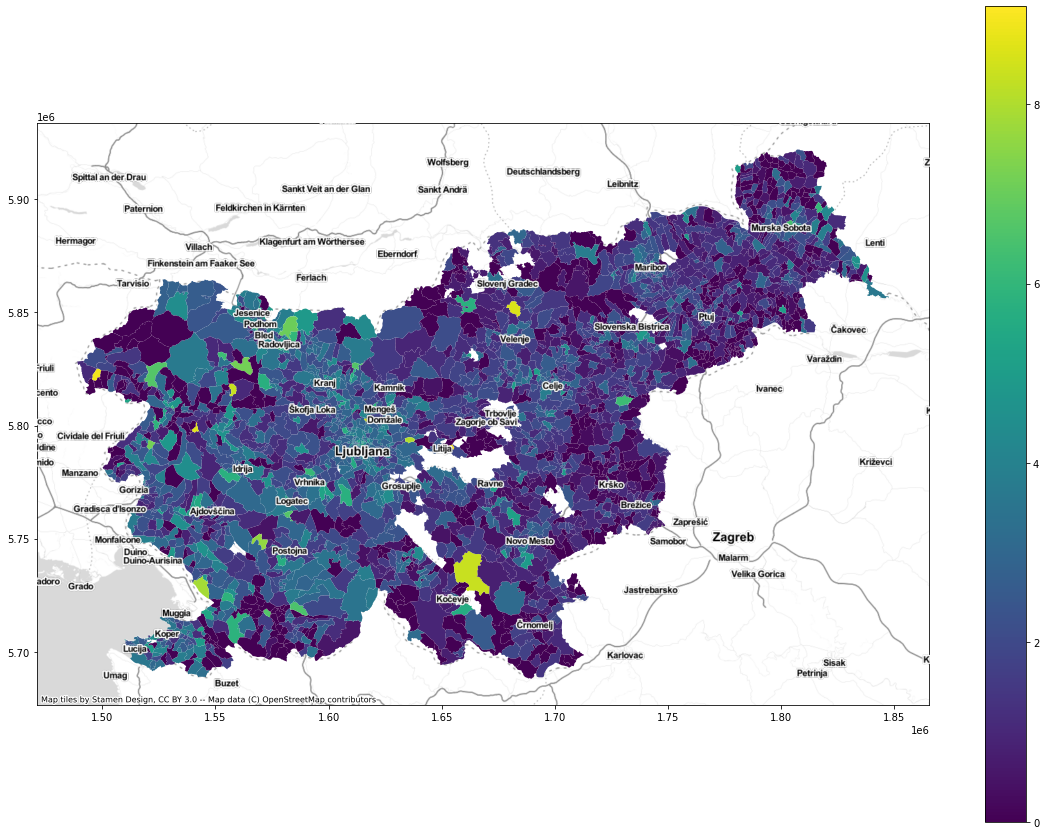

In [5]:
df["PODPORA"] = 100.0*(df["PIRATI"] / df["VELJAVNIH"])
df.head()
# df['PODPORA'].hist(bins=20)

Quantiles(df['PODPORA'], k=5)


ax = df.to_crs(epsg=3857).plot(column='PODPORA', figsize=(20, 15), legend=True)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)


In [15]:
df[['geometry']]

,geometry
N8,
707001,"POLYGON ((15.74382 46.51639, 15.74386 46.51651..."
707002,"POLYGON ((15.74382 46.51639, 15.74357 46.51634..."
707003,"POLYGON ((15.78827 46.50981, 15.78749 46.50983..."
707004,"POLYGON ((15.79558 46.50124, 15.79552 46.50106..."
707005,"POLYGON ((15.75707 46.53788, 15.75701 46.53812..."
...,...
408012,"POLYGON ((14.51567 46.09439, 14.51545 46.09457..."
408015,"POLYGON ((14.50829 46.08998, 14.50799 46.09002..."
808021,"POLYGON ((15.77579 46.70248, 15.77602 46.70222..."


In [19]:
map = folium.Map(location = [46.119944, 14.815333], tiles='OpenStreetMap' , zoom_start = 9)

df["N8"] = df.index

folium.Choropleth(
    geo_data=df[['N8', 'geometry']],
    data=df['PODPORA'],
    columns=['N8', 'PODPORA'],
    key_on='feature.properties.N8',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Podpora Piratom',
    smooth_factor=0).add_to(map)

# for _, r in df.iterrows():
#     # Without simplifying the representation of each borough,
#     # the map might not be displayed
#     sim_geo = gp.GeoSeries(r['geometry'])
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=lambda x: {'fillColor': hexcolor(r["PODPORA"], [0, 10]), 'color': '#ff0000', 'weight': 1})
#     folium.Popup("{} | {} | {}".format(r['VDV_UIME'], r["PODPORA"], r["VELJAVNIH"])).add_to(geo_j)
#     geo_j.add_to(map)
    

# plugins.HeatMap(list(zip(df.centroid.y, df.centroid.x, df["PODPORA"].fillna(0))), radius=5, max_zoom=5, min_opacity=1).add_to(map)

map.save('map.html')